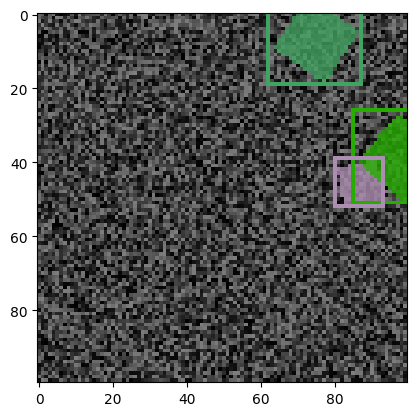

In [ ]:
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
import square_data_generator
from torchvision.utils import draw_bounding_boxes

N_SQUARES = 
IMAGE_SIZE = (100, 100)

test_img, test_bboxes, test_colors = square_data_generator.make_image(
    IMAGE_SIZE, N_SQUARES
)
pred_points = torchvision.ops.box_convert(test_bboxes, in_fmt="cxcywh", out_fmt="xyxy")

tuple_colors = [tuple(x.tolist()) for x in test_colors]

img_with_boxes = draw_bounding_boxes(
    (test_img.permute(2, 0, 1) * 255).to(torch.uint8),
    pred_points,
    colors=tuple_colors,
    width=1,
)
plt.imshow(img_with_boxes.permute(1, 2, 0));

In [12]:
from square_data_generator import label_sort_order_big_to_small


def ordered_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    _loss = 0

    for batch_idx in range(predicted_bboxes.size(0)):
        # sort_idx = label_sort_order_big_to_small(predicted_bboxes[batch_idx])
        for idx in range(N_SQUARES):
            _loss += nn.functional.mse_loss(
                predicted_bboxes[0, idx], target_bboxes[batch_idx][idx]
            )
    return _loss


def point_matching_loss(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    target_points = target_bboxes[:, :, :2]

    # random shuffle predicted bboxes
    pred_points = pred_points[torch.randperm(pred_points.size(0))]

    # greedy matching
    loss = 0
    removed = torch.zeros(N_SQUARES, dtype=torch.long)
    for batch_idx in range(pred_points.size(0)):
        for idx in range(N_SQUARES):
            # find the target bbox with the smallest L2 distance
            diff = target_points[batch_idx] - pred_points[batch_idx, idx]
            dists = torch.norm(diff, dim=1, p=2)
            dists[removed] = float("inf")
            print(dists)

            min_idx = torch.argmin(dists)
            removed[min_idx] = 1

            loss += nn.functional.mse_loss(
                pred_points[batch_idx, idx], target_points[batch_idx, min_idx]
            )

    print(loss)

    return loss


def calculate_iou_cxcywh(
    pred_boxes: torch.Tensor, target_boxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU for bounding boxes in cxcywh format
    Boxes are expected in format [center_x, center_y, width, height]
    """
    # Convert cxcywh to corner coordinates
    pred_cx, pred_cy, pred_w, pred_h = pred_boxes.unbind(-1)
    targ_cx, targ_cy, targ_w, targ_h = target_boxes.unbind(-1)

    # Calculate corner coordinates
    pred_x1 = pred_cx - pred_w / 2
    pred_y1 = pred_cy - pred_h / 2
    pred_x2 = pred_cx + pred_w / 2
    pred_y2 = pred_cy + pred_h / 2

    targ_x1 = targ_cx - targ_w / 2
    targ_y1 = targ_cy - targ_h / 2
    targ_x2 = targ_cx + targ_w / 2
    targ_y2 = targ_cy + targ_h / 2

    # Calculate intersection coordinates
    inter_x1 = torch.max(pred_x1, targ_x1)
    inter_y1 = torch.max(pred_y1, targ_y1)
    inter_x2 = torch.min(pred_x2, targ_x2)
    inter_y2 = torch.min(pred_y2, targ_y2)

    # Calculate intersection area
    inter_width = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_height = torch.clamp(inter_y2 - inter_y1, min=0)
    inter_area = inter_width * inter_height

    # Calculate union area
    pred_area = pred_w * pred_h
    targ_area = targ_w * targ_h
    union_area = pred_area + targ_area - inter_area

    # Calculate IoU
    iou = inter_area / (union_area + 1e-6)  # Add epsilon to avoid division by zero
    return iou


def ordered_iou_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU loss for ordered bounding boxes in cxcywh format
    Args:
        predicted_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
        target_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
    Returns:
        Total IoU loss
    """
    _loss = 0.0

    for batch_idx in range(predicted_bboxes.size(0)):
        for idx in range(5):  # Assuming 5 boxes as in original code
            # Calculate IoU for each pair of boxes
            iou = calculate_iou_cxcywh(
                predicted_bboxes[batch_idx, idx], target_bboxes[batch_idx, idx]
            )
            # Convert IoU to loss (1 - IoU)
            box_loss = 1 - iou
            _loss += box_loss

    return _loss


In [3]:
dataset = square_data_generator.SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=1000,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [13]:
import pred_model
import utils

# Training parameters

num_epochs = 2
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = pred_model.PointPredictor(n_output_boxes=N_SQUARES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_images = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, target_bboxes in dataloader:
        optimizer.zero_grad()
        pred_points = model(images)
        loss = point_matching_loss(pred_points, target_bboxes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

    model.eval()
    with torch.no_grad():
        test_pred_points = model(test_img.unsqueeze(0))
        test_images.append(utils.draw_points_on_image(test_img, test_pred_points[0]))


tensor([     inf, 100.3459,  39.7844], grad_fn=<IndexPutBackward0>)
tensor([    inf,     inf, 39.7382], grad_fn=<IndexPutBackward0>)
tensor([    inf,     inf, 39.8427], grad_fn=<IndexPutBackward0>)
tensor(2374.6829, grad_fn=<AddBackward0>)


RuntimeError: Found dtype Long but expected Float

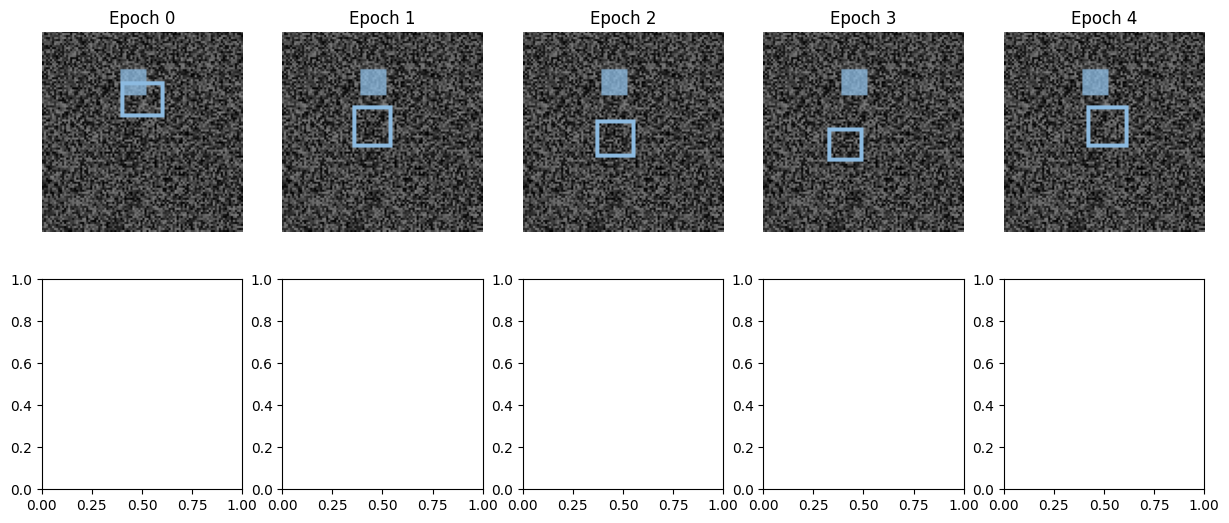

In [ ]:
# go through all images and plot them in a img grid
n_images = len(test_images)
n_cols = 5
n_rows = n_images // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
for i in range(n_images):
    this_ax = ax[i // n_cols, i % n_cols]
    this_ax.imshow(test_images[i].permute(1, 2, 0), origin="lower")
    this_ax.axis("off")
    this_ax.set_title(f"Epoch {i * EPOCH_PRINT_INTERVAL}")
plt.show()